In [766]:
# huge import stuff

! pip install lazypredict
! pip install chembl_webresource_client

from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
import sys


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
!unzip -o padel.zip
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
!pip install rdkit

sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2024-07-31 09:45:33--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 2606:4700::6810:20f1, 2606:4700::6810:bf9e, 104.16.191.158, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|2606:4700::6810:20f1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.13’

Miniconda3-py37_4.8 100%[===================>]  81.12M  53.4MB/s    in 1.5s    

2024-07-31 09:45:35 (53.4 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.13’ saved [85055499/85055499]

--2024-07-31 09:45:35--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]

  inflating: PaDEL-Descriptor/lib/jgrapht-0.6.0(2).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._jgrapht-0.6.0(2).jar  
  inflating: PaDEL-Descriptor/lib/libPaDEL-Descriptor(3).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._libPaDEL-Descriptor(3).jar  
  inflating: PaDEL-Descriptor/lib/commons-cli-1.2(4).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._commons-cli-1.2(4).jar  
  inflating: PaDEL-Descriptor/lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: PaDEL-Descriptor/lib/ambit2-smarts-2.4.7-SNAPSHOT(1).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._ambit2-smarts-2.4.7-SNAPSHOT(1).jar  
  inflating: PaDEL-Descriptor/lib/commons-cli-1.2.jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._commons-cli-1.2.jar  
  inflating: PaDEL-Descriptor/lib/commons-cli-1.2(8).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._commons-cli-1.2(8).jar  
  inflating: PaDEL-Descriptor/lib/jgrapht-0.6.0.jar  
  i

# Part 1

### Select Target Enzyme

In [767]:
# Target search for Monoamine Oxidase
target = new_client.target
target_query = target.search('Cyclooxygenase')
targets = pd.DataFrame.from_dict(target_query)
selected_target = targets.target_chembl_id[5]
selected_target

'CHEMBL230'

In [768]:
#Select Data with only IC50 values
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

### Instantiate and refine a Data Frame with compounds that target this enzyme


In [769]:
df = pd.DataFrame(res)

In [770]:
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,34205,[],CHEMBL762912,In vitro inhibitory activity against human pro...,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,IC50,uM,UO_0000065,None,0.06
1,None,None,34209,[],CHEMBL762912,In vitro inhibitory activity against human pro...,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,IC50,uM,UO_0000065,None,3.23
2,None,None,35476,[],CHEMBL762912,In vitro inhibitory activity against human pro...,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,IC50,uM,UO_0000065,None,0.08
3,None,None,36218,[],CHEMBL769655,Tested in vitro for inhibition against Prostag...,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,IC50,nM,UO_0000065,None,0.12
4,None,None,36708,[],CHEMBL762912,In vitro inhibitory activity against human pro...,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,IC50,uM,UO_0000065,None,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7886,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25107571,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5263959,Inhibition of human recombinant COX-II measure...,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,IC50,uM,UO_0000065,None,2.64
7887,None,None,25402925,[],CHEMBL5303789,Cross screening panel,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,pIC50,None,UO_0000065,None,4.0
7888,None,None,25402973,[],CHEMBL5303837,Cross screening panel,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,pIC50,None,UO_0000065,None,4.0
7889,None,None,25403909,[],CHEMBL5303886,Cross screening panel,B,None,None,BAO_0000190,...,Homo sapiens,Cyclooxygenase-2,9606,None,None,pIC50,None,UO_0000065,None,4.0


In [771]:
#Modify to only incude proteins that have a standard value and a unique canonical smile
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2_nr = df2.drop_duplicates(['canonical_smiles'])




#Select ChemblID, Canonical Smiles, and Standard Value columns from the Data Frame
selection=['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
#Create a bioactivity threshold column based on the standard values (states wehther a compound is active, inactive, or intermediate)
bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

bioactivity_class = pd.DataFrame(bioactivity_threshold, columns=['bioactivity_class'])
df3 = df3.reset_index(drop=True)
df5 = pd.concat([df3, bioactivity_class],axis=1)




#Filters the canonical smiles and only keeps the largest molecule within each SMILE
df_no_smiles = df5.drop(columns='canonical_smiles')
smiles = []

for i in df5.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)
smiles = pd.Series(smiles, name = 'canonical_smiles')

df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)

In [772]:
df_clean_smiles

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL297008,60.0,active,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1
1,CHEMBL289813,3230.0,intermediate,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1
2,CHEMBL43736,80.0,active,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...
3,CHEMBL140167,0.12,active,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1
4,CHEMBL44194,100000.0,inactive,CCc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1
...,...,...,...,...
5062,CHEMBL5290087,13700.0,inactive,COc1ccccc1-c1nnc(Cn2c(CN3CCOCC3)nc3ccccc32)o1
5063,CHEMBL4636881,100000.0,inactive,CC(=O)Nc1c(F)cc(C(=O)N[C@H]2CC[C@H](O)CC2)cc1O...
5064,CHEMBL4635134,100000.0,inactive,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O
5065,CHEMBL4639128,100000.0,inactive,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...


In [773]:
#Saving files? idk if its necessary
df3.to_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv', index=False)
! zip acetylcholinesterase.zip *.csv
! ls -l

updating: abbdescriptor_list.csv (deflated 94%)
updating: acetylcholinesterase_01_bioactivity_data_raw.csv (deflated 92%)
updating: acetylcholinesterase_02_bioactivity_data_preprocessed.csv (deflated 82%)
updating: acetylcholinesterase_03_bioactivity_data_curated.csv (deflated 82%)
updating: acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv (deflated 76%)
updating: acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv (deflated 74%)
updating: acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp (1).csv (deflated 95%)
updating: acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp (2).csv (deflated 95%)
updating: acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv (deflated 96%)
updating: adescriptor_list.csv (deflated 94%)
updating: bioactivity_data (1).csv (deflated 92%)
updating: bioactivity_data.csv (deflated 90%)
updating: bioactivity_data_preprocessed.csv (deflated 80%)
updating: bioactivity_preprocessed_data.csv (deflated 83%)
u

###  LIPINSKI DESCRIPTORS: Now that we have all of our data filtered and cleaned up, we will now calculate the Lipinsky descriptors for each molecule. These descriptors include the following:





##### Molecular Weight(<500 Daltons): 
This coincides with lower permeability and solubility, increasing avaliability for drug absorption orally
##### LogP/ Octanol-water partition coefficient (<5):
Indicates how much more partial the solubility of the molecule is to liipids when compares to water (can impact how it is absorbed and distributed throughout the patient)
##### Hydrogen Bond Donors(<5): 
Impacts the polarity within the compound, and having too many donors can reduce the amount that the compound can penetrate where it is needed. 
##### Hydrogen bond accepetors(<10):
Similar to the Bond donors, having less bond acceptors can affect solubility and polarity. 




##### Source:
Lipinski, C.A. Lead- and drug-like compounds: the rule-of-five revolution.
 Drug Discov. Today Technol. 1, 337-341 (2004)


In [774]:
#Function that takes a canonical smile as an input and then returns the four Lipinski descriptors. Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation. 
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    return descriptors

###  PIC50 VALUES
##### df_norm = norm_value(df_combined)


In [775]:
#Using the function, let's now create a list with both the original dataframe information, and the Lipinski descriptors
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_combined = pd.concat([df_clean_smiles,df_lipinski], axis=1)


In [776]:
#Norm-value function is created to normalize any outliers that are over 100,000,000 nanoMolars
def norm_value(input):
    norm = []
    float_list = list(map(float, (input['standard_value'].tolist())))
    for i in float_list:
        if i > 100000000:
          i = 100000000
        if i==0:
          i=1
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop(columns='standard_value')
    return x

#PIC50 function is used to take the normalized standard values, and create PIC50 values based on them (refer to header above for significance)
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop(columns='standard_value_norm')
        
    return x

#Now we can normalize, and generate the PIC50 values, assembling our final data frame
df_norm = norm_value(df_combined)
df_final = pIC50(df_norm)

In [777]:
#delete all intermediate values from the bioactivity class to insure. 
df_2class = df_final
#[df_final['bioactivity_class'] != 'intermediate']

In [778]:
df_2class.to_csv('df_2class.csv', index=False)

# Exploratory Data Analysis

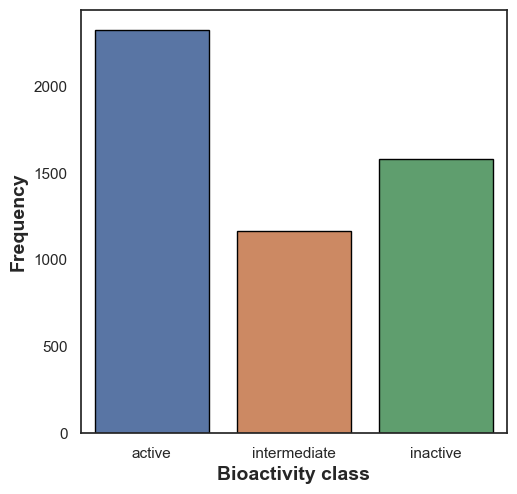

In [779]:
# Plotting
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('plot_bioactivity_class.pdf')
plt.show()

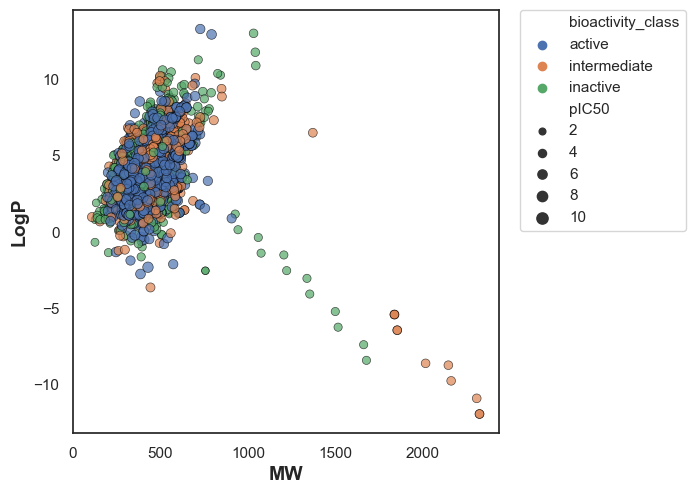

In [780]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

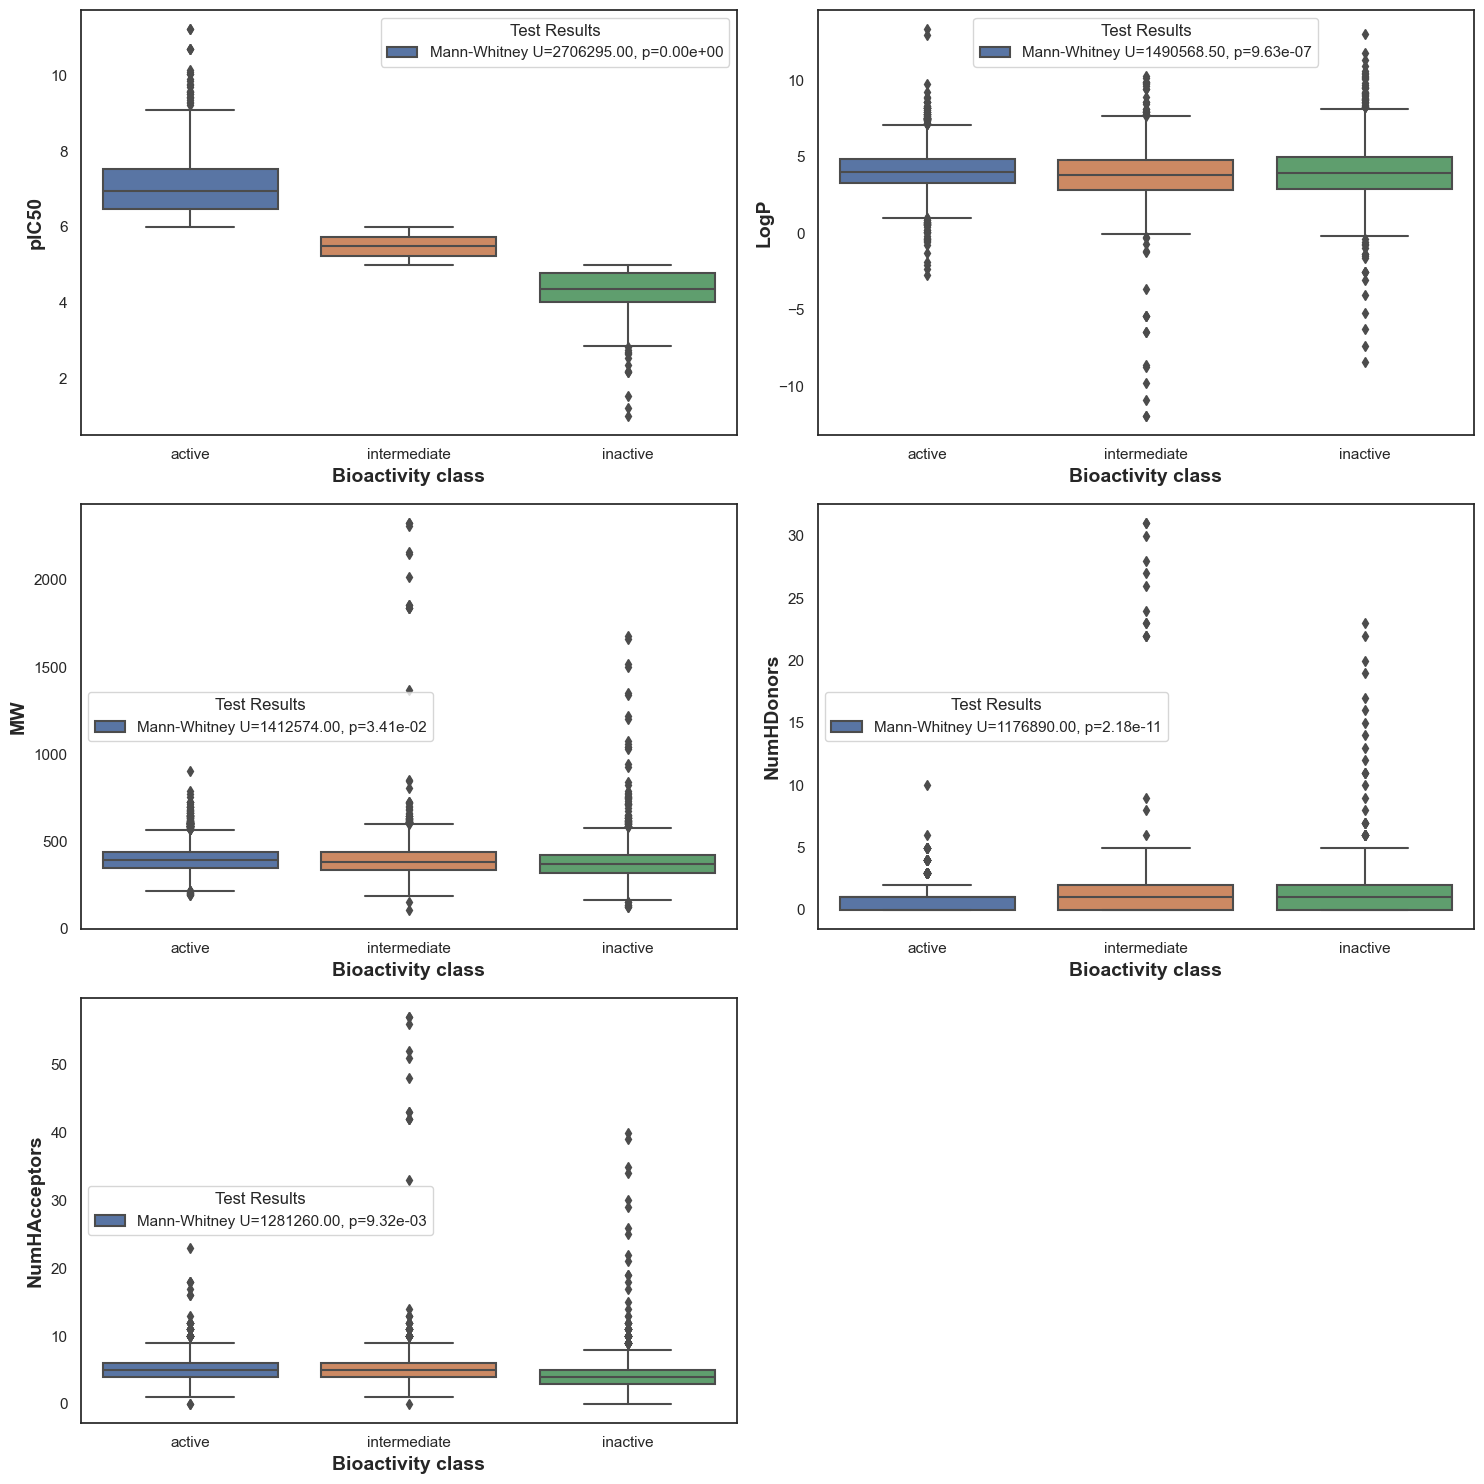

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,3668017.00,0.00,0.05,Different distribution (reject H0)
0,LogP,1921912.00,0.01,0.05,Different distribution (reject H0)
0,MW,2140415.50,0.00,0.05,Different distribution (reject H0)
0,NumHDonors,1590623.50,0.00,0.05,Different distribution (reject H0)
0,NumHAcceptors,2070495.00,0.00,0.05,Different distribution (reject H0)


In [781]:
#Establish Mannwhitney functions. 
def mannwhitney1(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results


results_final=[]
for vari in variables:
    results_final.append(mannwhitney1(vari))
results_final=pd.concat(results_final, axis=0)

def mannwhitney2(data, group, variable):
    # Sample implementation for Mann-Whitney U test
    from scipy.stats import mannwhitneyu
    group1 = data[data[group] == data[group].unique()[0]][variable]
    group2 = data[data[group] == data[group].unique()[1]][variable]
    stat, p = mannwhitneyu(group1, group2)
    return stat, p




# Create a figure with a grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# List of variables to plot

# Loop over the variables and axes
for ax, var in zip(axs.flat, variables):
    sns.boxplot(ax=ax, x='bioactivity_class', y=var, data=df_2class)
    ax.set_xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{var}', fontsize=14, fontweight='bold')
    # Calculate Mann-Whitney U test results
    stat, p = mannwhitney2(df_2class, 'bioactivity_class', var)
    # Set legend with Mann-Whitney results
    legend_text = f'Mann-Whitney U={stat:.2f}, p={p:.2e}'
    ax.legend([legend_text], title='Test Results')

# Remove the empty subplot (bottom right) if necessary
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.savefig('combined_plots.pdf')
plt.show()
results_final


For the following Lipinski descriptors, most of the active compounds are within the suitable range, and contain drug potential. 

# Part 4

In [782]:
selection = ['canonical_smiles','molecule_chembl_id']
df_2class_selection = df_2class[selection]
df_2class_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)
! cat padel.sh
! bash padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv
Processing CHEMBL297008 in molecule.smi (1/5067). 
Processing CHEMBL289813 in molecule.smi (2/5067). 
Processing CHEMBL43736 in molecule.smi (3/5067). 
Processing CHEMBL140167 in molecule.smi (4/5067). 
Processing CHEMBL44194 in molecule.smi (5/5067). 
Processing CHEMBL44290 in molecule.smi (6/5067). 
Processing CHEMBL288773 in molecule.smi (7/5067). 
Processing CHEMBL44068 in molecule.smi (8/5067). 
Processing CHEMBL297409 in molecule.smi (10/5067). Average speed: 1.40 s/mol.
Processing CHEMBL44367 in molecule.smi (9/5067). Average speed: 2.63 s/mol.
Processing CHEMBL43737 in molecule.smi (11/5067). Average speed: 1.41 s/mol.
Processing CHEMBL43511 in molecule.smi (12/5067). Average speed: 0.95 s/mol.
Processing CHEMBL42801 in molecule.smi (13/5067). Average

Processing CHEMBL145071 in molecule.smi (109/5067). Average speed: 0.07 s/mol.
Processing CHEMBL144232 in molecule.smi (110/5067). Average speed: 0.06 s/mol.
Processing CHEMBL282177 in molecule.smi (111/5067). Average speed: 0.06 s/mol.
Processing CHEMBL90988 in molecule.smi (113/5067). Average speed: 0.06 s/mol.
Processing CHEMBL145727 in molecule.smi (112/5067). Average speed: 0.06 s/mol.
Processing CHEMBL18264 in molecule.smi (114/5067). Average speed: 0.06 s/mol.
Processing CHEMBL146005 in molecule.smi (115/5067). Average speed: 0.06 s/mol.
Processing CHEMBL143113 in molecule.smi (116/5067). Average speed: 0.06 s/mol.
Processing CHEMBL18883 in molecule.smi (117/5067). Average speed: 0.06 s/mol.
Processing CHEMBL145247 in molecule.smi (118/5067). Average speed: 0.06 s/mol.
Processing CHEMBL144515 in molecule.smi (119/5067). Average speed: 0.06 s/mol.
Processing CHEMBL143340 in molecule.smi (120/5067). Average speed: 0.06 s/mol.
Processing CHEMBL282643 in molecule.smi (121/5067). Ave

Processing CHEMBL296447 in molecule.smi (215/5067). Average speed: 0.05 s/mol.
Processing CHEMBL298476 in molecule.smi (216/5067). Average speed: 0.05 s/mol.
Processing CHEMBL42408 in molecule.smi (217/5067). Average speed: 0.05 s/mol.
Processing CHEMBL43317 in molecule.smi (218/5067). Average speed: 0.05 s/mol.
Processing CHEMBL111057 in molecule.smi (219/5067). Average speed: 0.05 s/mol.
Processing CHEMBL55348 in molecule.smi (221/5067). Average speed: 0.05 s/mol.
Processing CHEMBL54746 in molecule.smi (220/5067). Average speed: 0.05 s/mol.
Processing CHEMBL54327 in molecule.smi (222/5067). Average speed: 0.05 s/mol.
Processing CHEMBL28491 in molecule.smi (223/5067). Average speed: 0.05 s/mol.
Processing CHEMBL325437 in molecule.smi (224/5067). Average speed: 0.05 s/mol.
Processing CHEMBL116252 in molecule.smi (225/5067). Average speed: 0.05 s/mol.
Processing CHEMBL154373 in molecule.smi (226/5067). Average speed: 0.05 s/mol.
Processing CHEMBL42549 in molecule.smi (227/5067). Average

Processing CHEMBL296384 in molecule.smi (321/5067). Average speed: 0.04 s/mol.
Processing CHEMBL282093 in molecule.smi (322/5067). Average speed: 0.04 s/mol.
Processing CHEMBL28636 in molecule.smi (323/5067). Average speed: 0.04 s/mol.
Processing CHEMBL432945 in molecule.smi (324/5067). Average speed: 0.04 s/mol.
Processing CHEMBL88549 in molecule.smi (325/5067). Average speed: 0.04 s/mol.
Processing CHEMBL91258 in molecule.smi (326/5067). Average speed: 0.04 s/mol.
Processing CHEMBL117491 in molecule.smi (327/5067). Average speed: 0.04 s/mol.
Processing CHEMBL118064 in molecule.smi (328/5067). Average speed: 0.04 s/mol.
Processing CHEMBL46584 in molecule.smi (329/5067). Average speed: 0.04 s/mol.
Processing CHEMBL42884 in molecule.smi (330/5067). Average speed: 0.04 s/mol.
Processing CHEMBL46636 in molecule.smi (331/5067). Average speed: 0.04 s/mol.
Processing CHEMBL325755 in molecule.smi (332/5067). Average speed: 0.04 s/mol.
Processing CHEMBL287646 in molecule.smi (334/5067). Averag

Processing CHEMBL28527 in molecule.smi (427/5067). Average speed: 0.04 s/mol.
Processing CHEMBL29923 in molecule.smi (428/5067). Average speed: 0.04 s/mol.
Processing CHEMBL28664 in molecule.smi (429/5067). Average speed: 0.04 s/mol.
Processing CHEMBL314297 in molecule.smi (430/5067). Average speed: 0.04 s/mol.
Processing CHEMBL1147 in molecule.smi (431/5067). Average speed: 0.04 s/mol.
Processing CHEMBL333755 in molecule.smi (432/5067). Average speed: 0.04 s/mol.
Processing CHEMBL435381 in molecule.smi (433/5067). Average speed: 0.04 s/mol.
Processing CHEMBL115979 in molecule.smi (434/5067). Average speed: 0.04 s/mol.
Processing CHEMBL349310 in molecule.smi (435/5067). Average speed: 0.04 s/mol.
Processing CHEMBL45192 in molecule.smi (436/5067). Average speed: 0.04 s/mol.
Processing CHEMBL417170 in molecule.smi (437/5067). Average speed: 0.04 s/mol.
Processing CHEMBL293771 in molecule.smi (438/5067). Average speed: 0.04 s/mol.
Processing CHEMBL30236 in molecule.smi (439/5067). Average

Processing CHEMBL158509 in molecule.smi (533/5067). Average speed: 0.03 s/mol.
Processing CHEMBL350422 in molecule.smi (534/5067). Average speed: 0.03 s/mol.
Processing CHEMBL161793 in molecule.smi (535/5067). Average speed: 0.03 s/mol.
Processing CHEMBL322305 in molecule.smi (536/5067). Average speed: 0.03 s/mol.
Processing CHEMBL44466 in molecule.smi (537/5067). Average speed: 0.03 s/mol.
Processing CHEMBL161590 in molecule.smi (538/5067). Average speed: 0.03 s/mol.
Processing CHEMBL420479 in molecule.smi (539/5067). Average speed: 0.03 s/mol.
Processing CHEMBL147074 in molecule.smi (540/5067). Average speed: 0.03 s/mol.
Processing CHEMBL149032 in molecule.smi (541/5067). Average speed: 0.03 s/mol.
Processing CHEMBL348041 in molecule.smi (542/5067). Average speed: 0.03 s/mol.
Processing CHEMBL345620 in molecule.smi (543/5067). Average speed: 0.03 s/mol.
Processing CHEMBL161377 in molecule.smi (544/5067). Average speed: 0.03 s/mol.
Processing CHEMBL110462 in molecule.smi (545/5067). A

Processing CHEMBL347441 in molecule.smi (639/5067). Average speed: 0.03 s/mol.
Processing CHEMBL18373 in molecule.smi (640/5067). Average speed: 0.03 s/mol.
Processing CHEMBL424303 in molecule.smi (641/5067). Average speed: 0.03 s/mol.
Processing CHEMBL444002 in molecule.smi (642/5067). Average speed: 0.03 s/mol.
Processing CHEMBL343853 in molecule.smi (643/5067). Average speed: 0.03 s/mol.
Processing CHEMBL37371 in molecule.smi (644/5067). Average speed: 0.03 s/mol.
Processing CHEMBL434014 in molecule.smi (645/5067). Average speed: 0.03 s/mol.
Processing CHEMBL357918 in molecule.smi (647/5067). Average speed: 0.03 s/mol.
Processing CHEMBL358246 in molecule.smi (646/5067). Average speed: 0.03 s/mol.
Processing CHEMBL287919 in molecule.smi (648/5067). Average speed: 0.03 s/mol.
Processing CHEMBL343198 in molecule.smi (649/5067). Average speed: 0.03 s/mol.
Processing CHEMBL153767 in molecule.smi (650/5067). Average speed: 0.03 s/mol.
Processing CHEMBL43520 in molecule.smi (651/5067). Ave

Processing CHEMBL432335 in molecule.smi (746/5067). Average speed: 0.03 s/mol.
Processing CHEMBL70588 in molecule.smi (745/5067). Average speed: 0.03 s/mol.
Processing CHEMBL306232 in molecule.smi (744/5067). Average speed: 0.03 s/mol.
Processing CHEMBL419268 in molecule.smi (747/5067). Average speed: 0.03 s/mol.
Processing CHEMBL69557 in molecule.smi (748/5067). Average speed: 0.03 s/mol.
Processing CHEMBL69261 in molecule.smi (749/5067). Average speed: 0.03 s/mol.
Processing CHEMBL71455 in molecule.smi (750/5067). Average speed: 0.03 s/mol.
Processing CHEMBL303728 in molecule.smi (752/5067). Average speed: 0.03 s/mol.
Processing CHEMBL304810 in molecule.smi (751/5067). Average speed: 0.03 s/mol.
Processing CHEMBL69667 in molecule.smi (753/5067). Average speed: 0.03 s/mol.
Processing CHEMBL70158 in molecule.smi (754/5067). Average speed: 0.03 s/mol.
Processing CHEMBL71052 in molecule.smi (756/5067). Average speed: 0.03 s/mol.
Processing CHEMBL70921 in molecule.smi (755/5067). Average 

Processing CHEMBL126369 in molecule.smi (852/5067). Average speed: 0.03 s/mol.
Processing CHEMBL295707 in molecule.smi (851/5067). Average speed: 0.03 s/mol.
Processing CHEMBL89392 in molecule.smi (853/5067). Average speed: 0.03 s/mol.
Processing CHEMBL126979 in molecule.smi (854/5067). Average speed: 0.03 s/mol.
Processing CHEMBL127868 in molecule.smi (855/5067). Average speed: 0.03 s/mol.
Processing CHEMBL43640 in molecule.smi (856/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1084 in molecule.smi (857/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2303697 in molecule.smi (858/5067). Average speed: 0.03 s/mol.
Processing CHEMBL43270 in molecule.smi (859/5067). Average speed: 0.03 s/mol.
Processing CHEMBL420351 in molecule.smi (861/5067). Average speed: 0.03 s/mol.
Processing CHEMBL42277 in molecule.smi (860/5067). Average speed: 0.03 s/mol.
Processing CHEMBL339258 in molecule.smi (862/5067). Average speed: 0.03 s/mol.
Processing CHEMBL127153 in molecule.smi (863/5067). Avera

Processing CHEMBL48758 in molecule.smi (956/5067). Average speed: 0.03 s/mol.
Processing CHEMBL368409 in molecule.smi (957/5067). Average speed: 0.03 s/mol.
Processing CHEMBL298356 in molecule.smi (958/5067). Average speed: 0.03 s/mol.
Processing CHEMBL49606 in molecule.smi (959/5067). Average speed: 0.03 s/mol.
Processing CHEMBL99199 in molecule.smi (960/5067). Average speed: 0.03 s/mol.
Processing CHEMBL319766 in molecule.smi (961/5067). Average speed: 0.03 s/mol.
Processing CHEMBL319999 in molecule.smi (962/5067). Average speed: 0.03 s/mol.
Processing CHEMBL97040 in molecule.smi (963/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2112399 in molecule.smi (964/5067). Average speed: 0.03 s/mol.
Processing CHEMBL319578 in molecule.smi (965/5067). Average speed: 0.03 s/mol.
Processing CHEMBL329480 in molecule.smi (966/5067). Average speed: 0.03 s/mol.
Processing CHEMBL97411 in molecule.smi (967/5067). Average speed: 0.03 s/mol.
Processing CHEMBL95052 in molecule.smi (968/5067). Avera

Processing CHEMBL166156 in molecule.smi (1061/5067). Average speed: 0.03 s/mol.
Processing CHEMBL349370 in molecule.smi (1062/5067). Average speed: 0.03 s/mol.
Processing CHEMBL338126 in molecule.smi (1063/5067). Average speed: 0.03 s/mol.
Processing CHEMBL164393 in molecule.smi (1064/5067). Average speed: 0.03 s/mol.
Processing CHEMBL349518 in molecule.smi (1065/5067). Average speed: 0.03 s/mol.
Processing CHEMBL339221 in molecule.smi (1066/5067). Average speed: 0.03 s/mol.
Processing CHEMBL423638 in molecule.smi (1067/5067). Average speed: 0.03 s/mol.
Processing CHEMBL129861 in molecule.smi (1068/5067). Average speed: 0.03 s/mol.
Processing CHEMBL527 in molecule.smi (1070/5067). Average speed: 0.03 s/mol.
Processing CHEMBL129308 in molecule.smi (1069/5067). Average speed: 0.03 s/mol.
Processing CHEMBL127642 in molecule.smi (1071/5067). Average speed: 0.03 s/mol.
Processing CHEMBL127494 in molecule.smi (1072/5067). Average speed: 0.03 s/mol.
Processing CHEMBL126808 in molecule.smi (10

Processing CHEMBL276739 in molecule.smi (1164/5067). Average speed: 0.03 s/mol.
Processing CHEMBL156482 in molecule.smi (1165/5067). Average speed: 0.03 s/mol.
Processing CHEMBL348115 in molecule.smi (1166/5067). Average speed: 0.03 s/mol.
Processing CHEMBL12532 in molecule.smi (1167/5067). Average speed: 0.03 s/mol.
Processing CHEMBL16353 in molecule.smi (1168/5067). Average speed: 0.03 s/mol.
Processing CHEMBL16878 in molecule.smi (1169/5067). Average speed: 0.03 s/mol.
Processing CHEMBL16819 in molecule.smi (1170/5067). Average speed: 0.03 s/mol.
Processing CHEMBL275188 in molecule.smi (1171/5067). Average speed: 0.03 s/mol.
Processing CHEMBL17229 in molecule.smi (1172/5067). Average speed: 0.03 s/mol.
Processing CHEMBL348645 in molecule.smi (1173/5067). Average speed: 0.03 s/mol.
Processing CHEMBL16828 in molecule.smi (1174/5067). Average speed: 0.03 s/mol.
Processing CHEMBL157714 in molecule.smi (1175/5067). Average speed: 0.03 s/mol.
Processing CHEMBL347378 in molecule.smi (1177/

Processing CHEMBL146854 in molecule.smi (1269/5067). Average speed: 0.03 s/mol.
Processing CHEMBL149506 in molecule.smi (1270/5067). Average speed: 0.03 s/mol.
Processing CHEMBL148931 in molecule.smi (1271/5067). Average speed: 0.03 s/mol.
Processing CHEMBL358500 in molecule.smi (1272/5067). Average speed: 0.03 s/mol.
Processing CHEMBL149213 in molecule.smi (1273/5067). Average speed: 0.03 s/mol.
Processing CHEMBL149335 in molecule.smi (1274/5067). Average speed: 0.03 s/mol.
Processing CHEMBL356203 in molecule.smi (1275/5067). Average speed: 0.03 s/mol.
Processing CHEMBL171335 in molecule.smi (1276/5067). Average speed: 0.03 s/mol.
Processing CHEMBL151441 in molecule.smi (1277/5067). Average speed: 0.03 s/mol.
Processing CHEMBL151929 in molecule.smi (1278/5067). Average speed: 0.03 s/mol.
Processing CHEMBL149775 in molecule.smi (1279/5067). Average speed: 0.03 s/mol.
Processing CHEMBL343865 in molecule.smi (1280/5067). Average speed: 0.03 s/mol.
Processing CHEMBL146703 in molecule.smi 

Processing CHEMBL106828 in molecule.smi (1374/5067). Average speed: 0.03 s/mol.
Processing CHEMBL106445 in molecule.smi (1375/5067). Average speed: 0.03 s/mol.
Processing CHEMBL107953 in molecule.smi (1376/5067). Average speed: 0.03 s/mol.
Processing CHEMBL432782 in molecule.smi (1377/5067). Average speed: 0.03 s/mol.
Processing CHEMBL106203 in molecule.smi (1378/5067). Average speed: 0.03 s/mol.
Processing CHEMBL39521 in molecule.smi (1379/5067). Average speed: 0.03 s/mol.
Processing CHEMBL275650 in molecule.smi (1380/5067). Average speed: 0.03 s/mol.
Processing CHEMBL278738 in molecule.smi (1381/5067). Average speed: 0.03 s/mol.
Processing CHEMBL18040 in molecule.smi (1382/5067). Average speed: 0.03 s/mol.
Processing CHEMBL19056 in molecule.smi (1383/5067). Average speed: 0.03 s/mol.
Processing CHEMBL18498 in molecule.smi (1384/5067). Average speed: 0.03 s/mol.
Processing CHEMBL18377 in molecule.smi (1385/5067). Average speed: 0.03 s/mol.
Processing CHEMBL277519 in molecule.smi (1386

Processing CHEMBL29662 in molecule.smi (1478/5067). Average speed: 0.03 s/mol.
Processing CHEMBL281457 in molecule.smi (1479/5067). Average speed: 0.03 s/mol.
Processing CHEMBL285828 in molecule.smi (1480/5067). Average speed: 0.03 s/mol.
Processing CHEMBL29941 in molecule.smi (1481/5067). Average speed: 0.03 s/mol.
Processing CHEMBL281847 in molecule.smi (1482/5067). Average speed: 0.03 s/mol.
Processing CHEMBL412307 in molecule.smi (1483/5067). Average speed: 0.03 s/mol.
Processing CHEMBL24869 in molecule.smi (1484/5067). Average speed: 0.03 s/mol.
Processing CHEMBL29943 in molecule.smi (1485/5067). Average speed: 0.03 s/mol.
Processing CHEMBL29575 in molecule.smi (1486/5067). Average speed: 0.03 s/mol.
Processing CHEMBL268470 in molecule.smi (1487/5067). Average speed: 0.03 s/mol.
Processing CHEMBL282390 in molecule.smi (1488/5067). Average speed: 0.03 s/mol.
Processing CHEMBL281653 in molecule.smi (1489/5067). Average speed: 0.03 s/mol.
Processing CHEMBL29075 in molecule.smi (1490/

Processing CHEMBL45247 in molecule.smi (1581/5067). Average speed: 0.03 s/mol.
Processing CHEMBL119472 in molecule.smi (1582/5067). Average speed: 0.03 s/mol.
Processing CHEMBL326295 in molecule.smi (1583/5067). Average speed: 0.03 s/mol.
Processing CHEMBL118839 in molecule.smi (1584/5067). Average speed: 0.03 s/mol.
Processing CHEMBL119720 in molecule.smi (1585/5067). Average speed: 0.03 s/mol.
Processing CHEMBL422075 in molecule.smi (1586/5067). Average speed: 0.03 s/mol.
Processing CHEMBL122065 in molecule.smi (1587/5067). Average speed: 0.03 s/mol.
Processing CHEMBL44319 in molecule.smi (1588/5067). Average speed: 0.03 s/mol.
Processing CHEMBL119418 in molecule.smi (1589/5067). Average speed: 0.03 s/mol.
Processing CHEMBL326365 in molecule.smi (1590/5067). Average speed: 0.03 s/mol.
Processing CHEMBL332937 in molecule.smi (1591/5067). Average speed: 0.03 s/mol.
Processing CHEMBL117911 in molecule.smi (1592/5067). Average speed: 0.03 s/mol.
Processing CHEMBL320433 in molecule.smi (1

Processing CHEMBL184145 in molecule.smi (1685/5067). Average speed: 0.03 s/mol.
Processing CHEMBL363102 in molecule.smi (1687/5067). Average speed: 0.03 s/mol.
Processing CHEMBL365060 in molecule.smi (1686/5067). Average speed: 0.03 s/mol.
Processing CHEMBL365865 in molecule.smi (1688/5067). Average speed: 0.03 s/mol.
Processing CHEMBL361472 in molecule.smi (1689/5067). Average speed: 0.03 s/mol.
Processing CHEMBL359775 in molecule.smi (1690/5067). Average speed: 0.03 s/mol.
Processing CHEMBL366102 in molecule.smi (1691/5067). Average speed: 0.03 s/mol.
Processing CHEMBL360182 in molecule.smi (1693/5067). Average speed: 0.03 s/mol.
Processing CHEMBL186632 in molecule.smi (1692/5067). Average speed: 0.03 s/mol.
Processing CHEMBL185621 in molecule.smi (1694/5067). Average speed: 0.03 s/mol.
Processing CHEMBL187468 in molecule.smi (1695/5067). Average speed: 0.03 s/mol.
Processing CHEMBL188115 in molecule.smi (1696/5067). Average speed: 0.03 s/mol.
Processing CHEMBL365267 in molecule.smi 

Processing CHEMBL384659 in molecule.smi (1789/5067). Average speed: 0.03 s/mol.
Processing CHEMBL222146 in molecule.smi (1790/5067). Average speed: 0.03 s/mol.
Processing CHEMBL375308 in molecule.smi (1791/5067). Average speed: 0.03 s/mol.
Processing CHEMBL223691 in molecule.smi (1792/5067). Average speed: 0.03 s/mol.
Processing CHEMBL388628 in molecule.smi (1793/5067). Average speed: 0.03 s/mol.
Processing CHEMBL390317 in molecule.smi (1794/5067). Average speed: 0.03 s/mol.
Processing CHEMBL224201 in molecule.smi (1795/5067). Average speed: 0.03 s/mol.
Processing CHEMBL224693 in molecule.smi (1796/5067). Average speed: 0.03 s/mol.
Processing CHEMBL224256 in molecule.smi (1797/5067). Average speed: 0.03 s/mol.
Processing CHEMBL389485 in molecule.smi (1798/5067). Average speed: 0.03 s/mol.
Processing CHEMBL225236 in molecule.smi (1799/5067). Average speed: 0.03 s/mol.
Processing CHEMBL224781 in molecule.smi (1800/5067). Average speed: 0.03 s/mol.
Processing CHEMBL374169 in molecule.smi 

Processing CHEMBL271930 in molecule.smi (1894/5067). Average speed: 0.03 s/mol.
Processing CHEMBL271911 in molecule.smi (1895/5067). Average speed: 0.03 s/mol.
Processing CHEMBL429915 in molecule.smi (1896/5067). Average speed: 0.03 s/mol.
Processing CHEMBL270246 in molecule.smi (1897/5067). Average speed: 0.03 s/mol.
Processing CHEMBL270670 in molecule.smi (1898/5067). Average speed: 0.03 s/mol.
Processing CHEMBL270671 in molecule.smi (1899/5067). Average speed: 0.03 s/mol.
Processing CHEMBL404921 in molecule.smi (1900/5067). Average speed: 0.03 s/mol.
Processing CHEMBL255175 in molecule.smi (1901/5067). Average speed: 0.03 s/mol.
Processing CHEMBL406434 in molecule.smi (1902/5067). Average speed: 0.03 s/mol.
Processing CHEMBL427835 in molecule.smi (1903/5067). Average speed: 0.03 s/mol.
Processing CHEMBL410524 in molecule.smi (1904/5067). Average speed: 0.03 s/mol.
Processing CHEMBL257054 in molecule.smi (1905/5067). Average speed: 0.03 s/mol.
Processing CHEMBL257295 in molecule.smi 

Processing CHEMBL408156 in molecule.smi (1997/5067). Average speed: 0.03 s/mol.
Processing CHEMBL407368 in molecule.smi (1999/5067). Average speed: 0.03 s/mol.
Processing CHEMBL76084 in molecule.smi (1998/5067). Average speed: 0.03 s/mol.
Processing CHEMBL407109 in molecule.smi (2000/5067). Average speed: 0.03 s/mol.
Processing CHEMBL259218 in molecule.smi (2001/5067). Average speed: 0.03 s/mol.
Processing CHEMBL261321 in molecule.smi (2003/5067). Average speed: 0.03 s/mol.
Processing CHEMBL261520 in molecule.smi (2002/5067). Average speed: 0.03 s/mol.
Processing CHEMBL260564 in molecule.smi (2004/5067). Average speed: 0.03 s/mol.
Processing CHEMBL442465 in molecule.smi (2005/5067). Average speed: 0.03 s/mol.
Processing CHEMBL260566 in molecule.smi (2006/5067). Average speed: 0.03 s/mol.
Processing CHEMBL261265 in molecule.smi (2007/5067). Average speed: 0.03 s/mol.
Processing CHEMBL261266 in molecule.smi (2008/5067). Average speed: 0.03 s/mol.
Processing CHEMBL408808 in molecule.smi (

Processing CHEMBL459814 in molecule.smi (2102/5067). Average speed: 0.03 s/mol.
Processing CHEMBL404515 in molecule.smi (2103/5067). Average speed: 0.03 s/mol.
Processing CHEMBL512400 in molecule.smi (2104/5067). Average speed: 0.03 s/mol.
Processing CHEMBL206765 in molecule.smi (2105/5067). Average speed: 0.03 s/mol.
Processing CHEMBL393292 in molecule.smi (2106/5067). Average speed: 0.03 s/mol.
Processing CHEMBL306946 in molecule.smi (2107/5067). Average speed: 0.03 s/mol.
Processing CHEMBL512227 in molecule.smi (2108/5067). Average speed: 0.03 s/mol.
Processing CHEMBL465371 in molecule.smi (2109/5067). Average speed: 0.03 s/mol.
Processing CHEMBL518543 in molecule.smi (2110/5067). Average speed: 0.03 s/mol.
Processing CHEMBL463571 in molecule.smi (2111/5067). Average speed: 0.03 s/mol.
Processing CHEMBL463559 in molecule.smi (2112/5067). Average speed: 0.03 s/mol.
Processing CHEMBL260553 in molecule.smi (2113/5067). Average speed: 0.03 s/mol.
Processing CHEMBL464006 in molecule.smi 

Processing CHEMBL490673 in molecule.smi (2206/5067). Average speed: 0.03 s/mol.
Processing CHEMBL490482 in molecule.smi (2207/5067). Average speed: 0.03 s/mol.
Processing CHEMBL473518 in molecule.smi (2208/5067). Average speed: 0.03 s/mol.
Processing CHEMBL482162 in molecule.smi (2209/5067). Average speed: 0.03 s/mol.
Processing CHEMBL467114 in molecule.smi (2210/5067). Average speed: 0.03 s/mol.
Processing CHEMBL470866 in molecule.smi (2211/5067). Average speed: 0.03 s/mol.
Processing CHEMBL500387 in molecule.smi (2212/5067). Average speed: 0.03 s/mol.
Processing CHEMBL503071 in molecule.smi (2213/5067). Average speed: 0.03 s/mol.
Processing CHEMBL502799 in molecule.smi (2214/5067). Average speed: 0.03 s/mol.
Processing CHEMBL525601 in molecule.smi (2215/5067). Average speed: 0.03 s/mol.
Processing CHEMBL526931 in molecule.smi (2216/5067). Average speed: 0.03 s/mol.
Processing CHEMBL504631 in molecule.smi (2217/5067). Average speed: 0.03 s/mol.
Processing CHEMBL517675 in molecule.smi 

Processing CHEMBL558727 in molecule.smi (2309/5067). Average speed: 0.03 s/mol.
Processing CHEMBL551148 in molecule.smi (2310/5067). Average speed: 0.03 s/mol.
Processing CHEMBL551830 in molecule.smi (2311/5067). Average speed: 0.03 s/mol.
Processing CHEMBL551829 in molecule.smi (2312/5067). Average speed: 0.03 s/mol.
Processing CHEMBL561086 in molecule.smi (2313/5067). Average speed: 0.03 s/mol.
Processing CHEMBL560887 in molecule.smi (2314/5067). Average speed: 0.03 s/mol.
Processing CHEMBL561950 in molecule.smi (2315/5067). Average speed: 0.03 s/mol.
Processing CHEMBL550069 in molecule.smi (2316/5067). Average speed: 0.03 s/mol.
Processing CHEMBL558230 in molecule.smi (2317/5067). Average speed: 0.03 s/mol.
Processing CHEMBL564962 in molecule.smi (2318/5067). Average speed: 0.03 s/mol.
Processing CHEMBL556929 in molecule.smi (2319/5067). Average speed: 0.03 s/mol.
Processing CHEMBL563455 in molecule.smi (2320/5067). Average speed: 0.03 s/mol.
Processing CHEMBL561888 in molecule.smi 

Processing CHEMBL1078557 in molecule.smi (2412/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1077442 in molecule.smi (2413/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1078682 in molecule.smi (2414/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1078683 in molecule.smi (2415/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1078860 in molecule.smi (2416/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1077436 in molecule.smi (2417/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1204023 in molecule.smi (2418/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1204024 in molecule.smi (2419/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1079073 in molecule.smi (2420/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1204025 in molecule.smi (2421/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1079074 in molecule.smi (2422/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1089958 in molecule.smi (2423/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1089959 in 

Processing CHEMBL1290434 in molecule.smi (2514/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1230348 in molecule.smi (2515/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288468 in molecule.smi (2516/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288469 in molecule.smi (2517/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1290459 in molecule.smi (2518/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288537 in molecule.smi (2519/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288538 in molecule.smi (2520/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288564 in molecule.smi (2522/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288539 in molecule.smi (2521/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1290563 in molecule.smi (2523/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288565 in molecule.smi (2524/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288566 in molecule.smi (2525/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1288600 in 

Processing CHEMBL446974 in molecule.smi (2616/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684141 in molecule.smi (2617/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684142 in molecule.smi (2618/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684146 in molecule.smi (2619/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684147 in molecule.smi (2620/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684148 in molecule.smi (2621/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684149 in molecule.smi (2622/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684150 in molecule.smi (2623/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684151 in molecule.smi (2624/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684152 in molecule.smi (2625/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1684153 in molecule.smi (2626/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1682229 in molecule.smi (2627/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1682230 in m

Processing CHEMBL1830479 in molecule.smi (2720/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1830480 in molecule.smi (2721/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1077 in molecule.smi (2722/5067). Average speed: 0.03 s/mol.
Processing CHEMBL291338 in molecule.smi (2724/5067). Average speed: 0.03 s/mol.
Processing CHEMBL195437 in molecule.smi (2723/5067). Average speed: 0.03 s/mol.
Processing CHEMBL496 in molecule.smi (2725/5067). Average speed: 0.03 s/mol.
Processing CHEMBL12131 in molecule.smi (2726/5067). Average speed: 0.03 s/mol.
Processing CHEMBL104 in molecule.smi (2727/5067). Average speed: 0.03 s/mol.
Processing CHEMBL828 in molecule.smi (2728/5067). Average speed: 0.03 s/mol.
Processing CHEMBL456807 in molecule.smi (2729/5067). Average speed: 0.03 s/mol.
Processing CHEMBL63323 in molecule.smi (2730/5067). Average speed: 0.03 s/mol.
Processing CHEMBL686 in molecule.smi (2731/5067). Average speed: 0.03 s/mol.
Processing CHEMBL91 in molecule.smi (2732/5067). Avera

Processing CHEMBL1957886 in molecule.smi (2822/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1958348 in molecule.smi (2823/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1958349 in molecule.smi (2824/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1958350 in molecule.smi (2825/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956381 in molecule.smi (2826/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956382 in molecule.smi (2827/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956383 in molecule.smi (2828/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956384 in molecule.smi (2829/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956385 in molecule.smi (2830/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956386 in molecule.smi (2831/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956387 in molecule.smi (2832/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956388 in molecule.smi (2833/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1956389 in 

Processing CHEMBL2158361 in molecule.smi (2924/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2158362 in molecule.smi (2925/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2158363 in molecule.smi (2926/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2158364 in molecule.smi (2927/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2158006 in molecule.smi (2928/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2158366 in molecule.smi (2930/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2158365 in molecule.smi (2929/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2160143 in molecule.smi (2931/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2160149 in molecule.smi (2932/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2160150 in molecule.smi (2933/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2160147 in molecule.smi (2934/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2160144 in molecule.smi (2935/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2160145 in 

Processing CHEMBL2283149 in molecule.smi (3026/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283148 in molecule.smi (3027/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283181 in molecule.smi (3028/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283180 in molecule.smi (3029/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283179 in molecule.smi (3030/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283178 in molecule.smi (3031/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283177 in molecule.smi (3032/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283176 in molecule.smi (3033/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2283175 in molecule.smi (3034/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2315327 in molecule.smi (3035/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2315326 in molecule.smi (3036/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2315325 in molecule.smi (3037/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2311577 in 

Processing CHEMBL2391048 in molecule.smi (3129/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2391054 in molecule.smi (3130/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398532 in molecule.smi (3131/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398542 in molecule.smi (3132/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398541 in molecule.smi (3133/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398540 in molecule.smi (3134/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398539 in molecule.smi (3135/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398538 in molecule.smi (3136/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398537 in molecule.smi (3137/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398536 in molecule.smi (3138/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398535 in molecule.smi (3139/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2398534 in molecule.smi (3140/5067). Average speed: 0.03 s/mol.
Processing CHEMBL513185 in m

Processing CHEMBL3264695 in molecule.smi (3233/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264696 in molecule.smi (3234/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264697 in molecule.smi (3235/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264698 in molecule.smi (3236/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264699 in molecule.smi (3237/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264700 in molecule.smi (3238/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264702 in molecule.smi (3240/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264701 in molecule.smi (3239/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264703 in molecule.smi (3241/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3264704 in molecule.smi (3242/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1242554 in molecule.smi (3243/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3265358 in molecule.smi (3244/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3265351 in 

Processing CHEMBL3309450 in molecule.smi (3339/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309449 in molecule.smi (3340/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309448 in molecule.smi (3341/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309447 in molecule.smi (3342/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309445 in molecule.smi (3344/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309446 in molecule.smi (3343/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309831 in molecule.smi (3348/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309832 in molecule.smi (3347/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309443 in molecule.smi (3346/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309444 in molecule.smi (3345/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309830 in molecule.smi (3349/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309829 in molecule.smi (3350/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3309828 in 

Processing CHEMBL3402334 in molecule.smi (3442/5067). Average speed: 0.03 s/mol.
Processing CHEMBL2181776 in molecule.smi (3443/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410338 in molecule.smi (3444/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410339 in molecule.smi (3445/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410340 in molecule.smi (3446/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410341 in molecule.smi (3447/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410342 in molecule.smi (3448/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410343 in molecule.smi (3449/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410344 in molecule.smi (3450/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410345 in molecule.smi (3451/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410346 in molecule.smi (3452/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410347 in molecule.smi (3453/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3410348 in 

Processing CHEMBL3740850 in molecule.smi (3544/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3742059 in molecule.smi (3545/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3741026 in molecule.smi (3546/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3741424 in molecule.smi (3547/5067). Average speed: 0.03 s/mol.
Processing CHEMBL12952 in molecule.smi (3548/5067). Average speed: 0.03 s/mol.
Processing CHEMBL15770 in molecule.smi (3549/5067). Average speed: 0.03 s/mol.
Processing CHEMBL553 in molecule.smi (3550/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3739528 in molecule.smi (3551/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3739527 in molecule.smi (3552/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3741768 in molecule.smi (3553/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3739771 in molecule.smi (3554/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3740105 in molecule.smi (3555/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3741490 in molecule

Processing CHEMBL3809154 in molecule.smi (3647/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3822753 in molecule.smi (3648/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823238 in molecule.smi (3649/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823600 in molecule.smi (3650/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823759 in molecule.smi (3651/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823814 in molecule.smi (3652/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823400 in molecule.smi (3653/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3824003 in molecule.smi (3654/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3822638 in molecule.smi (3655/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823276 in molecule.smi (3656/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3824071 in molecule.smi (3657/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823689 in molecule.smi (3659/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3823420 in 

Processing CHEMBL3945188 in molecule.smi (3751/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3950016 in molecule.smi (3752/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3918044 in molecule.smi (3753/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3914590 in molecule.smi (3754/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3937157 in molecule.smi (3755/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3909240 in molecule.smi (3756/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3323320 in molecule.smi (3757/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3931444 in molecule.smi (3758/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3979746 in molecule.smi (3759/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3927064 in molecule.smi (3760/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3912685 in molecule.smi (3761/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3926786 in molecule.smi (3762/5067). Average speed: 0.03 s/mol.
Processing CHEMBL1370630 in 

Processing CHEMBL4096865 in molecule.smi (3854/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4074351 in molecule.smi (3855/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4073566 in molecule.smi (3856/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4079032 in molecule.smi (3857/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4097045 in molecule.smi (3858/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4088012 in molecule.smi (3859/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4098347 in molecule.smi (3860/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4090622 in molecule.smi (3862/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4080317 in molecule.smi (3861/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4069602 in molecule.smi (3863/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4068589 in molecule.smi (3864/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4095906 in molecule.smi (3865/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4075294 in 

Processing CHEMBL4206085 in molecule.smi (3956/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4218075 in molecule.smi (3957/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4213360 in molecule.smi (3958/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4206988 in molecule.smi (3960/5067). Average speed: 0.03 s/mol.
Processing CHEMBL314774 in molecule.smi (3959/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4213903 in molecule.smi (3961/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4208086 in molecule.smi (3962/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4211316 in molecule.smi (3963/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4205552 in molecule.smi (3964/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4204840 in molecule.smi (3965/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4203006 in molecule.smi (3966/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4212465 in molecule.smi (3967/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4216007 in m

Processing CHEMBL4278024 in molecule.smi (4059/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4288684 in molecule.smi (4060/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4293163 in molecule.smi (4061/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4285341 in molecule.smi (4062/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4293285 in molecule.smi (4063/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4282681 in molecule.smi (4064/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4289901 in molecule.smi (4065/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4279217 in molecule.smi (4067/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4282685 in molecule.smi (4066/5067). Average speed: 0.03 s/mol.
Processing CHEMBL3581346 in molecule.smi (4068/5067). Average speed: 0.03 s/mol.
Processing CHEMBL374130 in molecule.smi (4069/5067). Average speed: 0.03 s/mol.
Processing CHEMBL223256 in molecule.smi (4070/5067). Average speed: 0.03 s/mol.
Processing CHEMBL463675 in mol

Processing CHEMBL4552101 in molecule.smi (4164/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4439374 in molecule.smi (4163/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4475455 in molecule.smi (4165/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4445481 in molecule.smi (4167/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4476757 in molecule.smi (4166/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4451916 in molecule.smi (4168/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4440769 in molecule.smi (4169/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4553634 in molecule.smi (4170/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4520676 in molecule.smi (4171/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4532838 in molecule.smi (4172/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4569865 in molecule.smi (4173/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4455944 in molecule.smi (4174/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4441218 in 

Processing CHEMBL4559991 in molecule.smi (4265/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4475190 in molecule.smi (4266/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4579799 in molecule.smi (4267/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4570970 in molecule.smi (4268/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4449234 in molecule.smi (4269/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4531165 in molecule.smi (4270/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4562695 in molecule.smi (4271/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4436821 in molecule.smi (4272/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4532877 in molecule.smi (4273/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4443644 in molecule.smi (4274/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4452534 in molecule.smi (4275/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4465079 in molecule.smi (4276/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4437752 in 

Processing CHEMBL4639025 in molecule.smi (4367/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4647794 in molecule.smi (4368/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4643407 in molecule.smi (4369/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4642268 in molecule.smi (4370/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4640385 in molecule.smi (4371/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4637009 in molecule.smi (4372/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4634111 in molecule.smi (4373/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4641800 in molecule.smi (4374/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4639368 in molecule.smi (4375/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4635616 in molecule.smi (4376/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4641524 in molecule.smi (4377/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4648342 in molecule.smi (4378/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4635572 in 

Processing CHEMBL4787953 in molecule.smi (4470/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4763941 in molecule.smi (4472/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4796006 in molecule.smi (4471/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4778555 in molecule.smi (4473/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4745894 in molecule.smi (4474/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4740435 in molecule.smi (4475/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4744314 in molecule.smi (4477/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4750050 in molecule.smi (4476/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4758065 in molecule.smi (4478/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4800449 in molecule.smi (4479/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4757345 in molecule.smi (4480/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4793035 in molecule.smi (4481/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4754406 in 

Processing CHEMBL4872636 in molecule.smi (4572/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4869763 in molecule.smi (4573/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4856646 in molecule.smi (4574/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4876862 in molecule.smi (4575/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4862389 in molecule.smi (4576/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4876293 in molecule.smi (4577/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4848882 in molecule.smi (4578/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4848763 in molecule.smi (4579/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4871207 in molecule.smi (4580/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4856727 in molecule.smi (4581/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4856182 in molecule.smi (4582/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4868808 in molecule.smi (4583/5067). Average speed: 0.03 s/mol.
Processing CHEMBL4856194 in 

Processing CHEMBL5188821 in molecule.smi (4674/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5170378 in molecule.smi (4675/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5201017 in molecule.smi (4676/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5184562 in molecule.smi (4677/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5200916 in molecule.smi (4678/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5190868 in molecule.smi (4679/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5209066 in molecule.smi (4680/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5191146 in molecule.smi (4681/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5203787 in molecule.smi (4682/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5180809 in molecule.smi (4684/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5177372 in molecule.smi (4683/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5204848 in molecule.smi (4685/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5191384 in 

Processing CHEMBL5279742 in molecule.smi (4776/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5273548 in molecule.smi (4777/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5285524 in molecule.smi (4778/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5288176 in molecule.smi (4779/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5281865 in molecule.smi (4780/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5290170 in molecule.smi (4781/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5283166 in molecule.smi (4782/5067). Average speed: 0.03 s/mol.
Processing CHEMBL222021 in molecule.smi (4783/5067). Average speed: 0.03 s/mol.
Processing CHEMBL37537 in molecule.smi (4784/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5283256 in molecule.smi (4785/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5282397 in molecule.smi (4786/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5276738 in molecule.smi (4787/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5286316 in mol

Processing CHEMBL5271327 in molecule.smi (4879/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5281317 in molecule.smi (4880/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5268637 in molecule.smi (4881/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5277139 in molecule.smi (4882/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5283826 in molecule.smi (4883/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5271852 in molecule.smi (4884/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5271091 in molecule.smi (4885/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5275245 in molecule.smi (4886/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5280343 in molecule.smi (4887/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5273576 in molecule.smi (4888/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5274575 in molecule.smi (4889/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5279070 in molecule.smi (4890/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5269313 in 

Processing CHEMBL5288258 in molecule.smi (4984/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5288740 in molecule.smi (4985/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5271933 in molecule.smi (4986/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5283867 in molecule.smi (4987/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5280475 in molecule.smi (4988/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5275155 in molecule.smi (4989/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5265784 in molecule.smi (4991/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5286858 in molecule.smi (4990/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5276315 in molecule.smi (4992/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5269887 in molecule.smi (4993/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5267823 in molecule.smi (4994/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5272619 in molecule.smi (4995/5067). Average speed: 0.03 s/mol.
Processing CHEMBL5269431 in 

In [783]:
! ls -l

total 27301992
-rw-r--r--@   1 satvikbandi  staff       28667 Dec 15  2023 111523 WellsFargo.pdf
-rw-r--r--    1 satvikbandi  staff    18175478 Jul 26 11:06 1monoamineoxidase_model.pkl
-rw-r--r--@   1 satvikbandi  staff       87197 Jan 23  2024 2004170348_Report_20240123173225.pdf
-rw-r--r--@   1 satvikbandi  staff       90571 Jan 23  2024 2004170348_Report_20240123173417.pdf
-rw-r--r--@   1 satvikbandi  staff       87753 Jan 23  2024 2004170348_Report_20240123173506.pdf
-rw-r--r--@   1 satvikbandi  staff       86997 Jan 23  2024 2004170348_Report_20240123173748.pdf
-rw-r--r--@   1 satvikbandi  staff       91857 Jan 23  2024 2004170348_Report_20240123174032.pdf
-rw-r--r--@   1 satvikbandi  staff       91048 Jan 23  2024 2004170348_Report_20240123174250.pdf
-rw-r--r--@   1 satvikbandi  staff       84069 Jan 23  2024 2004170348_Report_20240123174445.pdf
-rw-r--r--@   1 satvikbandi  staff    46827016 Feb 19 13:46 20210211_BE1_WholeSpine_SCOL (1).zip
-rw-r--r--@   1 satvikbandi  staff    4

In [784]:
#Create a dataset with 881 chemcial descriptors(based on the SMILE notation), and the corresponding pIC50 values
df6 = pd.read_csv('descriptors_output.csv')
df_X = df6.drop(columns=['Name'])
df_Y = df_2class['pIC50']
df_X = df_X.reset_index(drop=True)
df_Y = df_Y.reset_index(drop=True)
dataset = pd.concat([df_X, df_Y], axis=1)
X = dataset.drop('pIC50', axis=1)
Y = dataset.pIC50

# Remove low variance features
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=(.8 * (1 - .8))):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(df_X, (.8 * (1 - .8)))
X.shape
X.to_csv('descriptor_list.csv', index=False)

In [785]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


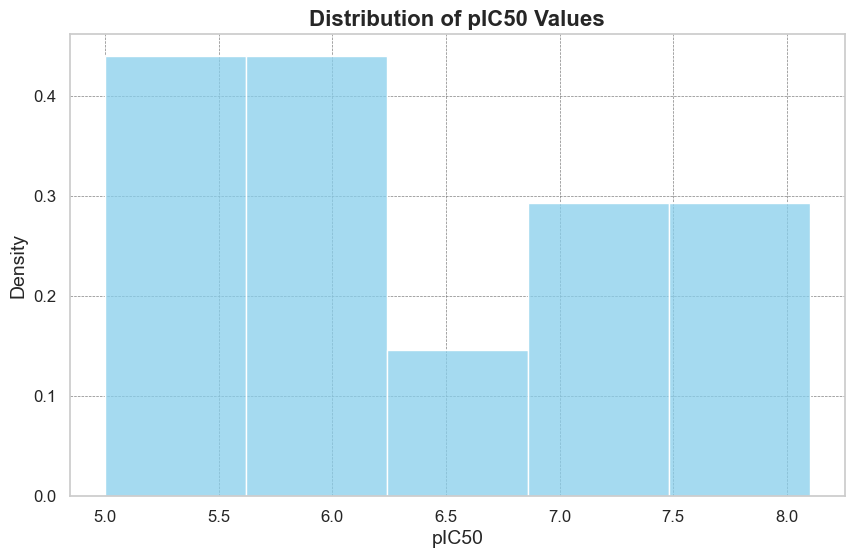

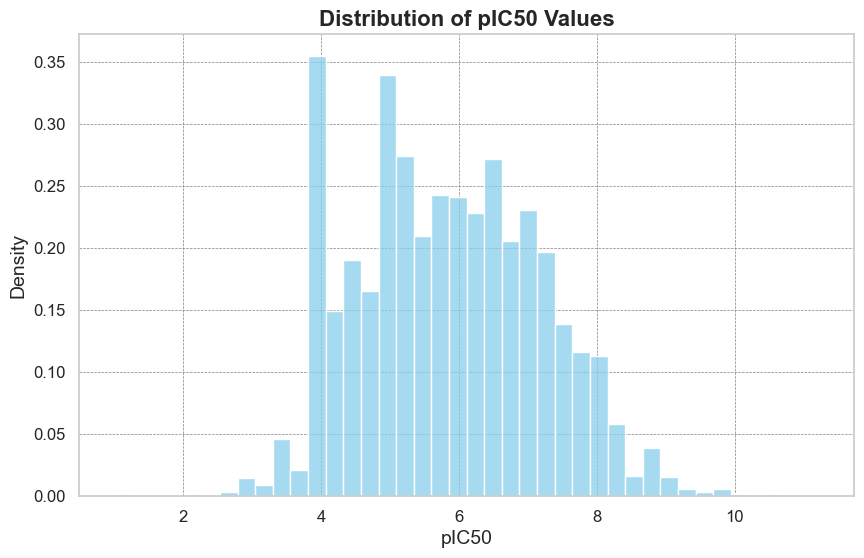

In [786]:
def plot_pic50_distribution(pic50_values, bins='auto', kde=False, hist=True):
    """
    Plot a clean bar-style distribution graph for a list of pIC50 values.
    
    Parameters:
    - pic50_values: list or array-like, the pIC50 values to plot.
    - bins: int or sequence or str, optional, the binning strategy for histogram.
    - kde: bool, optional, whether to include a kernel density estimate in the plot.
    - hist: bool, optional, whether to include a histogram in the plot.
    """
    # Set the aesthetic style of the plots for a cleaner look
    sns.set(style="whitegrid", palette="pastel")

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(pic50_values, bins=bins, kde=kde, color='skyblue', element="bars", stat="density", fill=True)
    
    # Adding labels and title with a clean aesthetic
    plt.title('Distribution of pIC50 Values', fontsize=16, fontweight='bold')
    plt.xlabel('pIC50', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Enhance grid visibility slightly
    
    # Reduce x and y ticks font size for a cleaner look
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Show the plot
    plt.show()

# Example usage with a sample of pIC50 values
example_pic50_values = [5.5, 6.0, 5.8, 7.2, 8.1, 5.0, 6.5, 7.0, 8.0, 5.1, 6.2]
plot_pic50_distribution(example_pic50_values)

plot_pic50_distribution(Y_train)

In [787]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)


Mean squared error (MSE): 0.64
Coefficient of determination (R62): 0.65


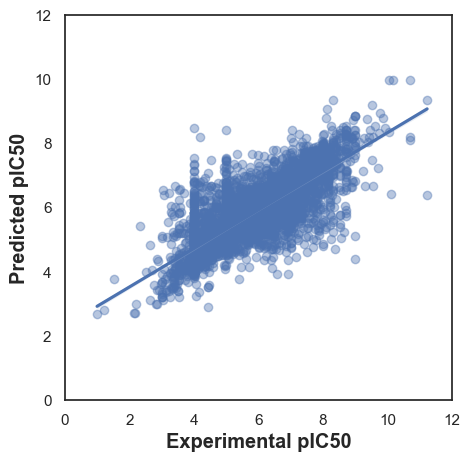

In [788]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
Y_pred = model.predict(X)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=Y, y=Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

from sklearn.metrics import mean_squared_error, r2_score
print('Mean squared error (MSE): %.2f' 
      % mean_squared_error(Y,Y_pred))
print('Coefficient of determination (R62): %.2f' 
      % r2_score(Y,Y_pred))

In [789]:
import pickle
pickle.dump(model, open('Cyclooxygenase.pkl','wb'))